# Mexican PIB Forecasting

- The data corresponds to the Gross Domestic Product (*Producto Interno Bruto*) in Mexico of the Financial and Insurance Services sector over the last 31 years. 
- Information extracted from the official website of the Mexican Central Bank in combination with INEGI.

## 1. Problem statement

The Financial and Insurance Services sector plays a critical role in Mexico's economy. However, predicting this sector's Gross Domestic Product (GDP) is challenging due to its dependence on various complex economic factors and market fluctuations. Traditional time series models often struggle to capture long-term dependencies and non-linear relationships in economic data. Therefore, this analysis aims to leverage advanced, recurrent neural network architectures, specifically Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) networks, to model and predict the Mexican GDP of the Financial and Insurance Services sector.

### Contents:
1. [Problem statement](#1.-Problem-statement)
2. [Preprocessing data](#2.-Preprocessing-data)
   1. [Requirements](#Requirements)
   2. [Time series extraction](#Time-series-extraction)
   3. [Tensor definition](#Tensor-definition)
3. [Training](#3.-Training)
   1. [LSTM](#LSTM-architecture)
   2. [GRU](#GRU-architecture)
4. [Results](#4.-Results)
   1. [LSTM](#LSTM)
   2. [GRU](#GRU)
   2. [Visualizations](#Visualizations)

## 2. Preprocessing data

### Requirements

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torchvision.utils as utils
from sklearn.preprocessing import MinMaxScaler

In [2]:
def get_date(epoch_time):
    epoch_time /= 1000
    return time.strftime('%Y-%m-%d', time.gmtime(epoch_time))

In [3]:
def get_labels(df):
    labels = []
    indxs = []
    for i in range(len(df['Time'])):
        if (i%4==0):
            label_str = df['Time'][i][:4]
            labels.append(label_str)
            indxs.append(i)
    return labels, indxs

In [4]:
def memory_cell(ordered_set, time_step):
    features, targets = [], []
    for indx in range(len(ordered_set)-time_step):
        indx_feature = ordered_set[indx:indx+time_step]
        indx_target = ordered_set[indx+1:indx+time_step+1]
        features.append(indx_feature)
        targets.append(indx_target)
    features = np.array(features)
    targets = np.array(targets)
    return torch.tensor(features, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

### Time series extraction

In [5]:
df_data = pd.read_csv('data/Producto-interno-bruto-trimestral.csv', usecols=['GDP', 'Time'])

In [6]:
df_data['Time'] = df_data['Time'].transform(lambda x: get_date(x))
df_data['GDP'] = df_data['GDP'].transform(lambda x: x/1000000000)
df_data = df_data.reindex(columns=['Time','GDP'])

In [7]:
train_size = round(0.7*df_data.shape[0])
train_set = df_data.iloc[:train_size-1] 
test_set = df_data.iloc[train_size:] 

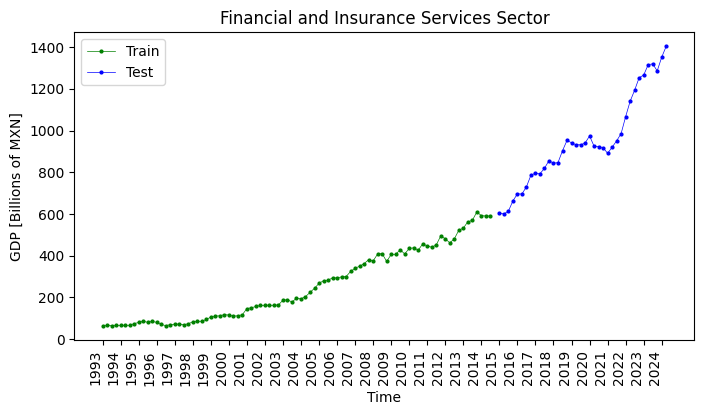

In [8]:
plt.figure(figsize=(8,4))
plt.plot(train_set['GDP'], label='Train', marker='.', markersize='4', linewidth='0.5', color='green')
plt.plot(test_set['GDP'], label='Test', marker='.', markersize='4', linewidth='0.5', color='blue')
plt.title('Financial and Insurance Services Sector')
plt.ylabel('GDP [Billions of MXN]')
labels, indxs = get_labels(df_data)
plt.xticks(indxs, labels, rotation=90, ha="right")
plt.xlabel('Time')
plt.legend() 
plt.show()

### Tensor definition

In [9]:
sc = MinMaxScaler(feature_range=(-1, 1))
data_np = np.array(df_data['GDP'])
data_np = data_np.reshape(-1, 1)
data_scaled = sc.fit_transform(data_np)
data_tensor = sc.inverse_transform(data_scaled)
data_scaled_tensor = torch.tensor(data_scaled, dtype=torch.float32)

In [10]:
train_np = np.array(train_set['GDP'])
train_np = train_np.reshape(-1, 1)
train_set_scaled = sc.fit_transform(train_np)
features_train, targets_train = memory_cell(train_set_scaled, time_step=3)
train_set_tensor = torch.utils.data.TensorDataset(features_train, targets_train)

In [11]:
test_np = np.array(test_set['GDP'])
test_np = test_np.reshape(-1, 1)
test_set_scaled = sc.fit_transform(test_np)
features_test, targets_test = memory_cell(test_set_scaled, time_step=3)
test_set_tensor = torch.utils.data.TensorDataset(features_test, targets_test)

## 3. Training

In [12]:
if torch.cuda.is_available(): 
    dev = "cuda:0"
else: 
    dev = "cpu"

In [13]:
class Learning_class():
    def __init__(self, model):
        self.epochs = 50
        self.device = torch.device(dev)
        self.model = model.to(self.device)
        self.loss_func = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.train_loss_hist = []
        self.test_loss_hist = []
        self.history = []

    def train_model(self):
        for epoch in range(self.epochs):
            train_loss = 0.0
            self.model.train()
            for scaled_batch, target_batch in self.model.train_loader:
                scaled_batch = scaled_batch.to(self.device)
                target_batch = target_batch.to(self.device)
                forecast_batch = self.model(scaled_batch)
                loss = self.loss_func(forecast_batch, target_batch)
                with torch.no_grad():
                    train_loss += loss.item()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            train_loss /= len(self.model.train_loader)
            
            test_loss = 0.0
            self.model.eval()
            with torch.inference_mode():
                for scaled_batch, target_batch in self.model.test_loader:
                    scaled_batch = scaled_batch.to(self.device)
                    target_batch = target_batch.to(self.device)
                    forecast_batch = self.model(scaled_batch)
                    loss = self.loss_func(forecast_batch, target_batch)
                    with torch.no_grad():
                        test_loss += loss.item()
                test_loss /= len(self.model.test_loader)
            
            print(f"Epoch: {epoch+1} Train loss: {train_loss: .5f} Test loss: {test_loss: .5f}")
            self.train_loss_hist.append(train_loss)
            self.test_loss_hist.append(test_loss)
            
        self.history.append(self.train_loss_hist)
        self.history.append(self.test_loss_hist)
        return self.model, self.history

### LSTM architecture

In [14]:
class LSTM(nn.Module):
    def __init__(self, train_set, test_set):
        self.batch_size = 64
        self.train_loader = torch.utils.data.DataLoader(dataset=train_set_tensor,
                                                        batch_size=self.batch_size,
                                                        shuffle=True)        
        self.test_loader = torch.utils.data.DataLoader(dataset=test_set_tensor,
                                                        batch_size=self.batch_size,
                                                        shuffle=False)        
        super(LSTM, self).__init__()      
        self.lstm_layer_1 = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.fully_layer_2 = nn.Sequential(nn.Linear(64, 32))
        self.fully_layer_3 = nn.Sequential(nn.Linear(32, 1))

    def forward(self, input_seq):
        out, _ = self.lstm_layer_1(input_seq)
        out = self.fully_layer_2(out)
        out = self.fully_layer_3(out)
        return out

In [15]:
lstm_model = LSTM(train_set_scaled, test_set_scaled)
lstm_learning_model = Learning_class(lstm_model)
lstm_trained_model, lstm_history = lstm_learning_model.train_model()

Epoch: 1 Train loss:  0.48317 Test loss:  0.24952
Epoch: 2 Train loss:  0.43620 Test loss:  0.24215
Epoch: 3 Train loss:  0.45247 Test loss:  0.23586
Epoch: 4 Train loss:  0.42668 Test loss:  0.23054
Epoch: 5 Train loss:  0.36724 Test loss:  0.22606
Epoch: 6 Train loss:  0.35417 Test loss:  0.22247
Epoch: 7 Train loss:  0.35782 Test loss:  0.21983
Epoch: 8 Train loss:  0.36264 Test loss:  0.21810
Epoch: 9 Train loss:  0.32823 Test loss:  0.21707
Epoch: 10 Train loss:  0.29275 Test loss:  0.21675
Epoch: 11 Train loss:  0.27334 Test loss:  0.21729
Epoch: 12 Train loss:  0.27964 Test loss:  0.21797
Epoch: 13 Train loss:  0.28309 Test loss:  0.21744
Epoch: 14 Train loss:  0.25533 Test loss:  0.21552
Epoch: 15 Train loss:  0.24724 Test loss:  0.21137
Epoch: 16 Train loss:  0.26434 Test loss:  0.20527
Epoch: 17 Train loss:  0.23543 Test loss:  0.19661
Epoch: 18 Train loss:  0.21720 Test loss:  0.18477
Epoch: 19 Train loss:  0.19644 Test loss:  0.16994
Epoch: 20 Train loss:  0.18910 Test loss

### GRU architecture

In [16]:
class GRU(nn.Module):
    def __init__(self, train_set, test_set):
        self.batch_size = 64
        self.train_loader = torch.utils.data.DataLoader(dataset=train_set_tensor,
                                                        batch_size=self.batch_size,
                                                        shuffle=True)        
        self.test_loader = torch.utils.data.DataLoader(dataset=test_set_tensor,
                                                        batch_size=self.batch_size,
                                                        shuffle=False)        
        super(GRU, self).__init__()      
        self.gru_layer_1 = nn.GRU(input_size=1, hidden_size=64, batch_first=True)
        self.fully_layer_2 = nn.Sequential(nn.Linear(64, 32))
        self.fully_layer_3 = nn.Sequential(nn.Linear(32, 1))

    def forward(self, input_seq):
        out, _ = self.gru_layer_1(input_seq)
        out = self.fully_layer_2(out)
        out = self.fully_layer_3(out)
        return out

In [17]:
gru_model = GRU(train_set_scaled, test_set_scaled)
gru_learning_model = Learning_class(gru_model)
gru_trained_model, gru_history = gru_learning_model.train_model()

Epoch: 1 Train loss:  0.34208 Test loss:  0.23405
Epoch: 2 Train loss:  0.35004 Test loss:  0.22725
Epoch: 3 Train loss:  0.28010 Test loss:  0.21929
Epoch: 4 Train loss:  0.33237 Test loss:  0.21059
Epoch: 5 Train loss:  0.27842 Test loss:  0.20081
Epoch: 6 Train loss:  0.26471 Test loss:  0.19119
Epoch: 7 Train loss:  0.25393 Test loss:  0.18077
Epoch: 8 Train loss:  0.22425 Test loss:  0.16954
Epoch: 9 Train loss:  0.22559 Test loss:  0.15770
Epoch: 10 Train loss:  0.19848 Test loss:  0.14366
Epoch: 11 Train loss:  0.15967 Test loss:  0.12705
Epoch: 12 Train loss:  0.12471 Test loss:  0.10985
Epoch: 13 Train loss:  0.11306 Test loss:  0.09366
Epoch: 14 Train loss:  0.09610 Test loss:  0.07820
Epoch: 15 Train loss:  0.09391 Test loss:  0.06369
Epoch: 16 Train loss:  0.06709 Test loss:  0.05129
Epoch: 17 Train loss:  0.05782 Test loss:  0.04314
Epoch: 18 Train loss:  0.04723 Test loss:  0.03966
Epoch: 19 Train loss:  0.05335 Test loss:  0.03977
Epoch: 20 Train loss:  0.05126 Test loss

## 4. Results

### LSTM

In [18]:
lstm_trained_model.eval()
lstm_trained_model.to(torch.device('cpu'))
lstm_predicted = lstm_trained_model(data_scaled_tensor).detach().numpy()
lstm_predicted = sc.inverse_transform(lstm_predicted)
print(f"LSTM MSE Loss: {lstm_history[0][-1]: 0.5f}")

LSTM MSE Loss:  0.03503


### GRU

In [19]:
gru_trained_model.eval()
gru_trained_model.to(torch.device('cpu'))
gru_predicted = gru_trained_model(data_scaled_tensor).detach().numpy()
gru_predicted = sc.inverse_transform(gru_predicted)
print(f"GRU MSE Loss: {gru_history[0][-1]: 0.5f}")

GRU MSE Loss:  0.01003


### Visualizations

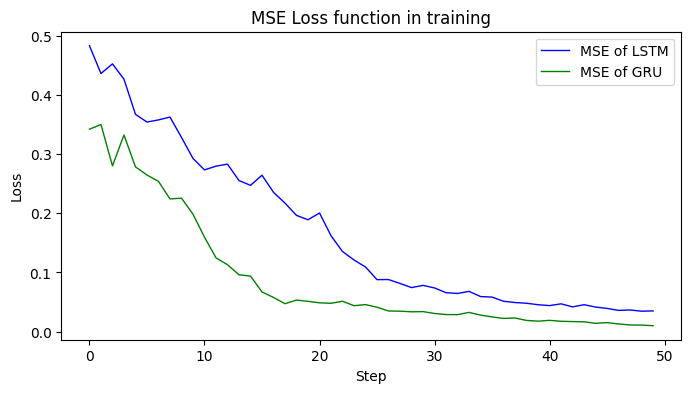

In [20]:
plt.figure(figsize=(8,4))
plt.plot(lstm_history[0], label='MSE of LSTM', linewidth='1', color='blue')
plt.plot(gru_history[0], label='MSE of GRU', linewidth='1', color='green')
plt.title('MSE Loss function in training')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.legend() 
plt.show()

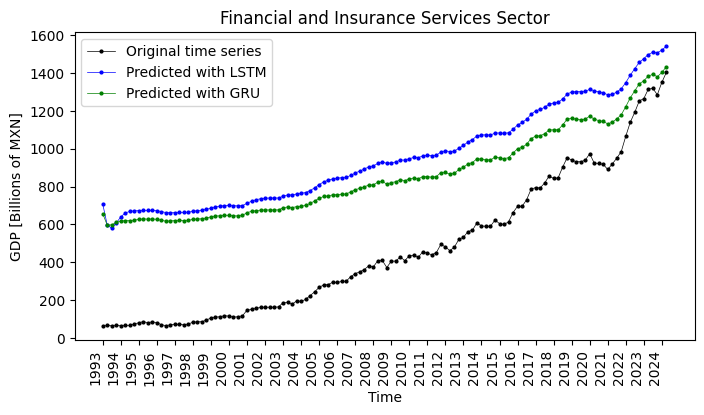

In [21]:
plt.figure(figsize=(8,4))
plt.plot(data_tensor, label='Original time series', marker='.', markersize='4', linewidth='0.5', color='black')
plt.plot(lstm_predicted, label='Predicted with LSTM', marker='.', markersize='4', linewidth='0.5', color='blue')
plt.plot(gru_predicted, label='Predicted with GRU', marker='.', markersize='4', linewidth='0.5', color='green')
plt.title('Financial and Insurance Services Sector')
plt.ylabel('GDP [Billions of MXN]')
labels, indxs = get_labels(df_data)
plt.xticks(indxs, labels, rotation=90, ha="right")
plt.xlabel('Time')
plt.legend() 
plt.show()